# Data: Lake Michigan Waves

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

Can we predict wave height based on wave period (time between waves)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [2]:
df = pd.read_csv("waves.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Calumet Beach,04/07/2018 12:30:00 AM,21.7,3.15,NaN,0.389,3.0,0.0,04/07/2018 12:30 AM,CalumetBeach201804072430
1,Ohio Street Beach,06/14/2019 07:00:00 PM,16.0,2.18,NaN,0.137,3.0,11.8,06/14/2019 7:00 PM,OhioStreetBeach201906141900
2,Ohio Street Beach,05/16/2018 01:00:00 PM,21.7,1.92,NaN,0.023,1.0,10.3,05/16/2018 1:00 PM,OhioStreetBeach201805161300
3,Ohio Street Beach,05/16/2018 02:00:00 PM,21.9,1.81,NaN,0.026,6.0,10.3,05/16/2018 2:00 PM,OhioStreetBeach201805161400
4,Ohio Street Beach,06/04/2018 09:00:00 AM,23.0,0.03,NaN,0.021,8.0,12.4,06/04/2018 9:00 AM,OhioStreetBeach201806040900


<AxesSubplot:xlabel='Wave Period', ylabel='Wave Height'>

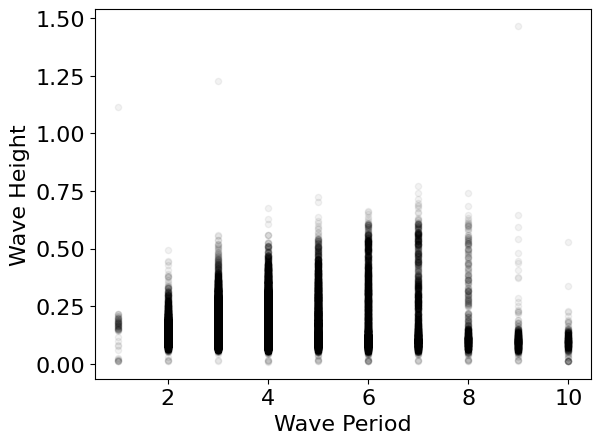

In [3]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)
# observation: non-linear relationship

In [4]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

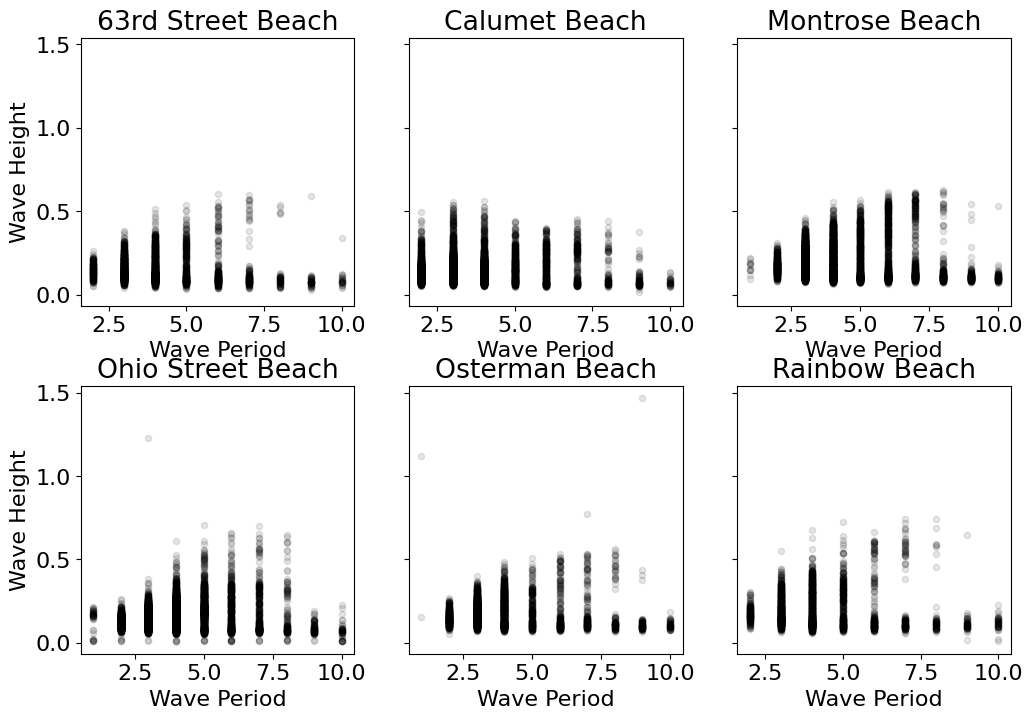

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)
# obversation: which beach (categorical feature) is important

# Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [7]:
train, test = train_test_split(df, random_state=320)
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
28817,Ohio Street Beach,07/04/2019 04:00:00 PM,21.5,0.94,NaN,0.137,4.0,11.8,07/04/2019 4:00 PM,OhioStreetBeach201907041600
13162,Calumet Beach,08/07/2016 04:00:00 PM,25.5,0.67,NaN,0.253,2.0,9.8,08/07/2016 4:00 PM,CalumetBeach201608071600
13110,Calumet Beach,08/05/2016 11:00:00 AM,24.1,1.03,NaN,0.173,3.0,10.1,08/05/2016 11:00 AM,CalumetBeach201608051100
23538,Ohio Street Beach,06/15/2015 08:00:00 AM,18.0,1.25,NaN,0.066,4.0,11.9,06/15/2015 8:00 AM,OhioStreetBeach201506150800
30642,Ohio Street Beach,07/29/2017 07:00:00 PM,23.4,3.80,NaN,0.187,3.0,11.5,07/29/2017 7:00 PM,OhioStreetBeach201707291900


## Model 1: Wave Period (Linear)

In [8]:
m1 = LinearRegression()
scores = cross_val_score(m1, train[["Wave Period"]], train["Wave Height"], cv=10)
scores

array([0.00454499, 0.00482062, 0.00061888, 0.00133774, 0.00212657,
       0.0045607 , 0.00502461, 0.00087125, 0.00324929, 0.00139911])

In [9]:
scores.mean()   # we want this to be big (but it's not)

0.002855376036731605

In [10]:
scores.std()    # we want this to be small

0.0016846248473168155

## Model 2: Wave Period (Polynomial)

LinearRegression can this:

```
y = 3*x1 + 5*x2

It CANNOT do this:

y = 3*x + 5*x^2

TRICK:

x1 = x
x2 = x^2
```

In [14]:
# ADVICE: don't change the data referred to by a specific variable throughout your code

train2 = train[["Wave Period"]].copy()
train2.head()

,Wave Period
28817,4.0
13162,2.0
13110,3.0
23538,4.0
30642,3.0


In [15]:
train2["Wave Period ^ 2"] = train2["Wave Period"] ** 2
train2["Wave Period ^ 3"] = train2["Wave Period"] ** 3
train2["sqrt(Wave Period"] = train2["Wave Period"] ** 0.5
train2.head()

,Wave Period,Wave Period ^ 2,Wave Period ^ 3,sqrt(Wave Period
28817,4.0,16.0,64.0,2.000000
13162,2.0,4.0,8.0,1.414214
13110,3.0,9.0,27.0,1.732051
23538,4.0,16.0,64.0,2.000000
30642,3.0,9.0,27.0,1.732051


In [20]:
pf = PolynomialFeatures(degree=4, include_bias=False)
pf.fit(train[["Wave Period"]])
pd.DataFrame(pf.transform(train[["Wave Period"]]), columns=pf.get_feature_names_out()).head()

,Wave Period,Wave Period^2,Wave Period^3,Wave Period^4
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0


In [21]:
# fit_transform is a shortcut for fit followed by transform
new_data = pf.fit_transform(train[["Wave Period"]])
pd.DataFrame(new_data, columns=pf.get_feature_names_out()).head()

,Wave Period,Wave Period^2,Wave Period^3,Wave Period^4
0,4.0,16.0,64.0,256.0
1,2.0,4.0,8.0,16.0
2,3.0,9.0,27.0,81.0
3,4.0,16.0,64.0,256.0
4,3.0,9.0,27.0,81.0


In [22]:
m2 = Pipeline([
    ("pf", PolynomialFeatures()),
    ("lr", LinearRegression())
])
m2

Pipeline(steps=[('pf', PolynomialFeatures()), ('lr', LinearRegression())])

In [23]:
scores = cross_val_score(m2, train[["Wave Period"]], train["Wave Height"], cv=10)
scores.mean()

0.04899677725538598

## Model 3: Beach Name (Categorical)

In [25]:
# IDEA 1:
# Ohio => 1
# Calumet => 2
# Osterman => 3
# ...
# PROBLEM: Calumet is in no way an average of beaches 1+3 (but the model will try to force it to be)
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
28817,Ohio Street Beach,07/04/2019 04:00:00 PM,21.5,0.94,NaN,0.137,4.0,11.8,07/04/2019 4:00 PM,OhioStreetBeach201907041600
13162,Calumet Beach,08/07/2016 04:00:00 PM,25.5,0.67,NaN,0.253,2.0,9.8,08/07/2016 4:00 PM,CalumetBeach201608071600
13110,Calumet Beach,08/05/2016 11:00:00 AM,24.1,1.03,NaN,0.173,3.0,10.1,08/05/2016 11:00 AM,CalumetBeach201608051100
23538,Ohio Street Beach,06/15/2015 08:00:00 AM,18.0,1.25,NaN,0.066,4.0,11.9,06/15/2015 8:00 AM,OhioStreetBeach201506150800
30642,Ohio Street Beach,07/29/2017 07:00:00 PM,23.4,3.80,NaN,0.187,3.0,11.5,07/29/2017 7:00 PM,OhioStreetBeach201707291900


In [29]:
oh = OneHotEncoder()
pd.DataFrame(oh.fit_transform(train[["Beach Name"]]).toarray(), columns=oh.get_feature_names_out())

,Beach Name_63rd Street Beach,Beach Name_Calumet Beach,Beach Name_Montrose Beach,Beach Name_Ohio Street Beach,Beach Name_Osterman Beach,Beach Name_Rainbow Beach
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
29866,0.0,0.0,0.0,0.0,1.0,0.0
29867,0.0,0.0,0.0,1.0,0.0,0.0
29868,0.0,0.0,0.0,0.0,1.0,0.0
29869,1.0,0.0,0.0,0.0,0.0,0.0


In [30]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression())
])
m3

Pipeline(steps=[('oh', OneHotEncoder()), ('lr', LinearRegression())])

In [31]:
scores = cross_val_score(m3, train[["Beach Name"]], train["Wave Height"], cv=10)
scores.mean()

0.04564252182679625

## Model 4: Beach Name and Wave Period (Polynomial)